In [75]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

In [76]:
#load datasets
df_train = pd.read_csv("/content/Google_Stock_Price_Test.csv")
df_test = pd.read_csv("/content/Google_Stock_Price_Train.csv")

In [77]:
df_train.head()

,Date,Open,High,Low,Close,Volume
0,1/3/2017,778.81,789.63,775.80,786.14,"1,657,300"
1,1/4/2017,788.36,791.34,783.16,786.90,"1,073,000"
2,1/5/2017,786.08,794.48,785.02,794.02,"1,335,200"
3,1/6/2017,795.26,807.90,792.20,806.15,"1,640,200"
4,1/9/2017,806.40,809.97,802.83,806.65,"1,272,400"


In [78]:
df_test.head()

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"


In [79]:
#combine datasets
combined_df = pd.concat([df_train, df_test], axis=0).reset_index(drop=True)

#data preprocessing
def preprocess_stock_data(data, window_size=60, scaler=None, is_train=True):
    data['Date'] = pd.to_datetime(data['Date'])
    data = data.sort_values('Date').reset_index(drop=True)
    for col in ['Open', 'High', 'Low', 'Close', 'Volume']:
        data[col] = data[col].replace(',', '', regex=True).astype(float)
    numerical_features = ['Open', 'High', 'Low', 'Close', 'Volume']
    if scaler is None:
        scaler = MinMaxScaler(feature_range=(0, 1))
        data[numerical_features] = scaler.fit_transform(data[numerical_features])
    else:
        data[numerical_features] = scaler.transform(data[numerical_features])
    X, Y = [], []
    for i in range(window_size, len(data)):
        X.append(data.loc[i-window_size:i-1, numerical_features].values)
        Y.append(data.loc[i, 'Close'])
    X = np.array(X)
    Y = np.array(Y)
    if is_train:
        return X, Y, scaler
    else:
        return X, Y


In [80]:
#preprocess the data
window_size = 60
X_combined, Y_combined, scaler = preprocess_stock_data(combined_df, window_size=window_size, is_train=True)

#split the data
dataset_size = len(X_combined)
train_size = int(0.6 * dataset_size)
val_size = int(0.2 * dataset_size)

X_train, Y_train = X_combined[:train_size], Y_combined[:train_size]
X_val, Y_val = X_combined[train_size:train_size+val_size], Y_combined[train_size:train_size+val_size]
X_test, Y_test = X_combined[train_size+val_size:], Y_combined[train_size+val_size:]

#check shapes
print('X_train.shape =', X_train.shape)
print('Y_train.shape =', Y_train.shape)
print('X_val.shape =', X_val.shape)
print('Y_val.shape =', Y_val.shape)
print('X_test.shape =', X_test.shape)
print('Y_test.shape =', Y_test.shape)

X_train.shape = (730, 60, 5)
Y_train.shape = (730,)
X_val.shape = (243, 60, 5)
Y_val.shape = (243,)
X_test.shape = (245, 60, 5)
Y_test.shape = (245,)


In [81]:
#convert to pytorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
Y_train = torch.tensor(Y_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
Y_val = torch.tensor(Y_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
Y_test = torch.tensor(Y_test, dtype=torch.float32)


In [82]:
#Vanilla RNN Model
class VanillaRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(VanillaRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

#LSTM Model
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

#GRU Model
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(GRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1, :])
        return out

In [115]:
#Training
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for X_batch, Y_batch in train_loader:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs.squeeze(), Y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_batch, Y_batch in val_loader:
                X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs.squeeze(), Y_batch)
                val_loss += loss.item()

        print(f"Epoch {epoch+1}/{num_epochs}:- Training Loss: {train_loss/len(train_loader):.4f}, Validation Loss: {val_loss/len(val_loader):.4f}")

In [116]:
#Evaluation
def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0.0
    predictions, actuals = [], []
    with torch.no_grad():
        for X_batch, Y_batch in test_loader:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs.squeeze(), Y_batch)
            test_loss += loss.item()
            predictions.append(outputs.cpu().numpy())
            actuals.append(Y_batch.cpu().numpy())
    predictions = np.concatenate(predictions).flatten()
    actuals = np.concatenate(actuals).flatten()
    return test_loss / len(test_loader), predictions, actuals

In [122]:
#Hyperparameters
num_layers_list = [2, 3]
optimizers_list = ['adam', 'sgd']
learning_rates = [0.01, 0.001]
epochs = 20
batch_size = 32
input_size = X_train.shape[2]
hidden_size = 50
output_size = 1
criterion = nn.MSELoss()
device = "cpu"

In [123]:
#loaders
train_dataset = torch.utils.data.TensorDataset(X_train, Y_train)
val_dataset = torch.utils.data.TensorDataset(X_val, Y_val)
test_dataset = torch.utils.data.TensorDataset(X_test, Y_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [124]:
#train and evaluate models with all configurations
best_models = {}
for ModelClass, model_name in [(VanillaRNN, 'VanillaRNN'), (LSTM, 'LSTM'), (GRU, 'GRU')]:
    for num_layers in num_layers_list:
        for opt_name in optimizers_list:
            for lr in learning_rates:
                print(f"\nTraining {model_name}: num_layers = {num_layers}, optimizer = {opt_name}, lr = {lr}")
                model = ModelClass(input_size, hidden_size, output_size, num_layers).to(device)

                #choose optimizer
                if opt_name == 'adam':
                    optimizer = optim.Adam(model.parameters(), lr=lr)
                elif opt_name == 'sgd':
                    optimizer = optim.SGD(model.parameters(), lr=lr)

                train_model(model, train_loader, val_loader, criterion, optimizer, epochs, device)

                print(f"Evaluating {model_name}: num_layers = {num_layers}, optimizer = {opt_name}, lr = {lr}")
                test_loss, predictions, actuals = evaluate_model(model, test_loader, criterion, device)
                mae = mean_absolute_error(actuals, predictions)
                mse = mean_squared_error(actuals, predictions)
                r2 = r2_score(actuals, predictions)

                config_key = f"{model_name}_layers{num_layers}_opt{opt_name}_lr{lr}"
                best_models[config_key] = {
                    'model_name': model_name,
                    'model': model,
                    'test_loss': test_loss,
                    'mae': mae,
                    'mse': mse,
                    'r2': r2,
                    'predictions': predictions,
                    'actuals': actuals,
                    'num_layers': num_layers,
                    'optimizer': opt_name,
                    'lr': lr
                }

#identify the best configuration for each model type
model_types = ['VanillaRNN', 'LSTM', 'GRU']
best_config_per_model = {}

for mtype in model_types:
    #filter configs for this model type
    filtered_configs = {k:v for k,v in best_models.items() if v['model_name'] == mtype}
    #find best (lowest test_loss)
    best_key = min(filtered_configs, key=lambda x: filtered_configs[x]['test_loss'])
    best_config_per_model[mtype] = best_models[best_key]


Training VanillaRNN: num_layers = 2, optimizer = adam, lr = 0.01
Epoch 1/20:- Training Loss: 0.0513, Validation Loss: 0.0008
Epoch 2/20:- Training Loss: 0.0031, Validation Loss: 0.0008
Epoch 3/20:- Training Loss: 0.2049, Validation Loss: 0.7848
Epoch 4/20:- Training Loss: 0.2003, Validation Loss: 0.0318
Epoch 5/20:- Training Loss: 0.0849, Validation Loss: 0.0159
Epoch 6/20:- Training Loss: 0.0808, Validation Loss: 0.0537
Epoch 7/20:- Training Loss: 0.0803, Validation Loss: 0.0793
Epoch 8/20:- Training Loss: 0.0778, Validation Loss: 0.0308
Epoch 9/20:- Training Loss: 0.0766, Validation Loss: 0.0137
Epoch 10/20:- Training Loss: 0.0745, Validation Loss: 0.0165
Epoch 11/20:- Training Loss: 0.0656, Validation Loss: 0.0290
Epoch 12/20:- Training Loss: 0.0701, Validation Loss: 0.0085
Epoch 13/20:- Training Loss: 0.0160, Validation Loss: 0.0012
Epoch 14/20:- Training Loss: 0.0049, Validation Loss: 0.0011
Epoch 15/20:- Training Loss: 0.0027, Validation Loss: 0.0024
Epoch 16/20:- Training Loss:

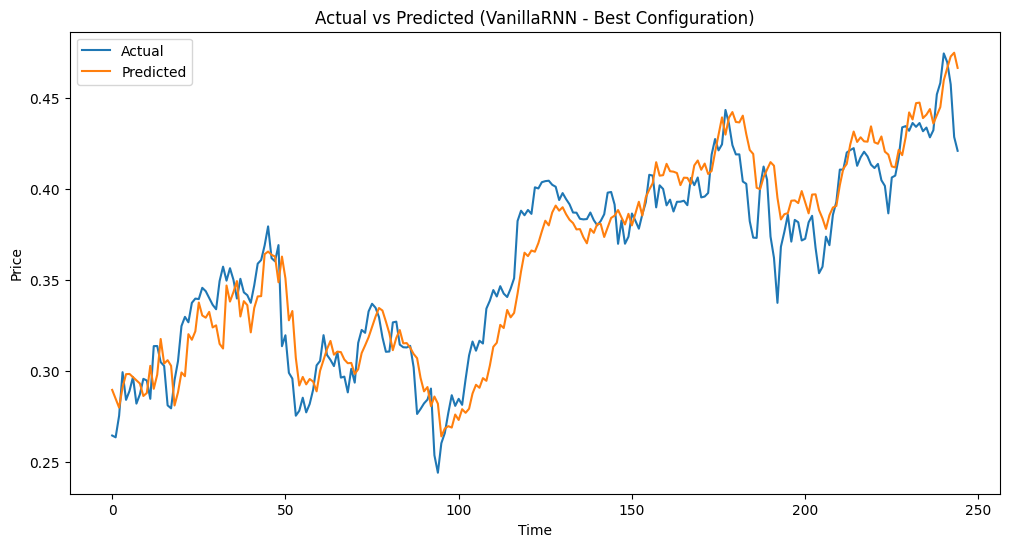

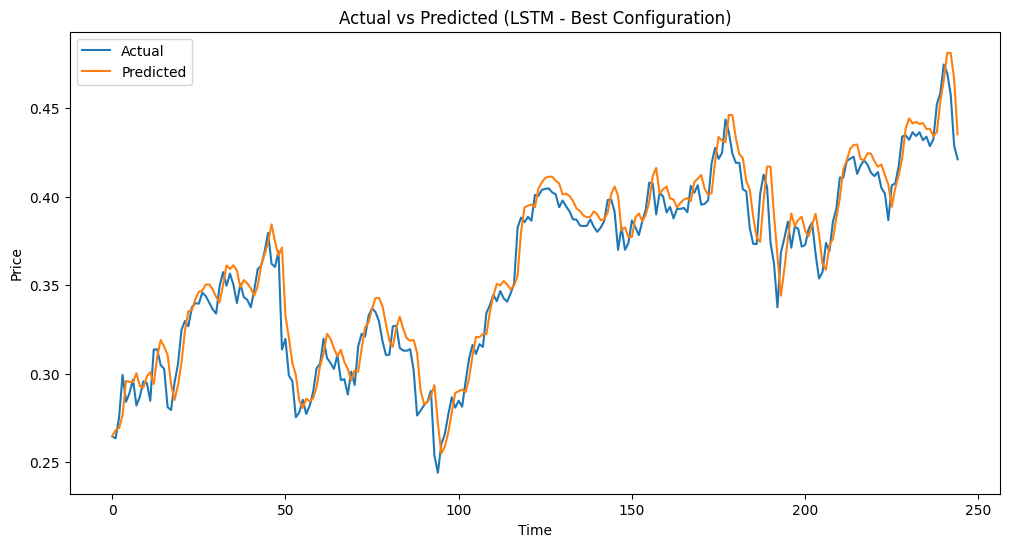

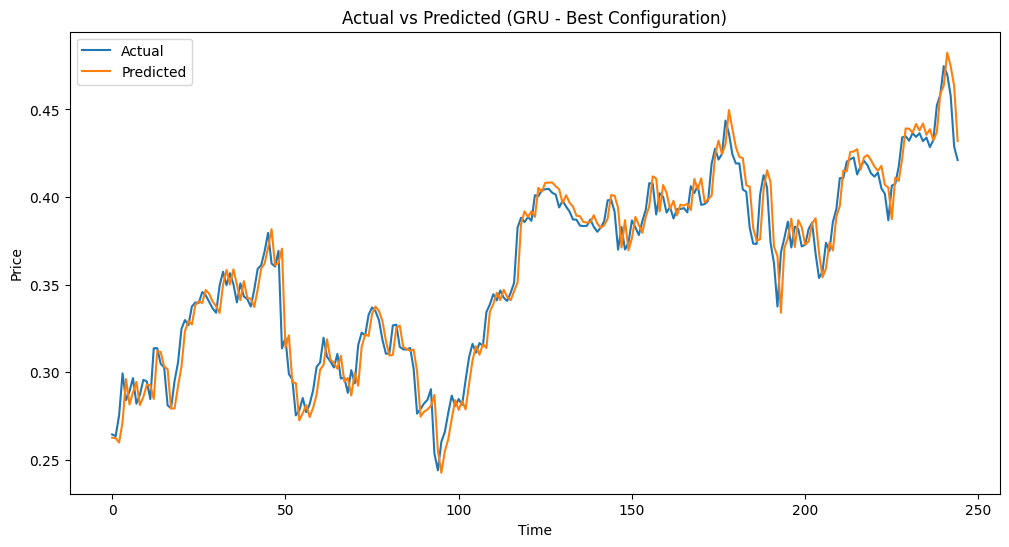

In [125]:
#plot the best configurations for each model individually
for mtype, details in best_config_per_model.items():
    predictions = details['predictions']
    actuals = details['actuals']
    plt.figure(figsize=(12, 6))
    plt.plot(actuals, label="Actual")
    plt.plot(predictions, label="Predicted")
    plt.title(f"Actual vs Predicted ({mtype} - Best Configuration)")
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.legend()
    plt.show()

In [126]:
#print the parameters and metrics of the best configurations
print("\nBest Configurations Results:")
for mtype, details in best_config_per_model.items():
    print(f"{mtype}:")
    print(f"  Best parameters -> num_layers: {details['num_layers']}, optimizer: {details['optimizer']}, lr: {details['lr']}")
    print(f"  Test Loss: {details['test_loss']:.4f}")
    print(f"  MAE: {details['mae']:.4f}")
    print(f"  MSE: {details['mse']:.4f}")
    print(f"  R²: {details['r2']:.4f}\n")


Best Configurations Results:
VanillaRNN:
  Best parameters -> num_layers: 3, optimizer: adam, lr: 0.01
  Test Loss: 0.0003
  MAE: 0.0148
  MSE: 0.0003
  R²: 0.8683

LSTM:
  Best parameters -> num_layers: 2, optimizer: adam, lr: 0.01
  Test Loss: 0.0002
  MAE: 0.0100
  MSE: 0.0002
  R²: 0.9360

GRU:
  Best parameters -> num_layers: 2, optimizer: adam, lr: 0.01
  Test Loss: 0.0001
  MAE: 0.0088
  MSE: 0.0001
  R²: 0.9466



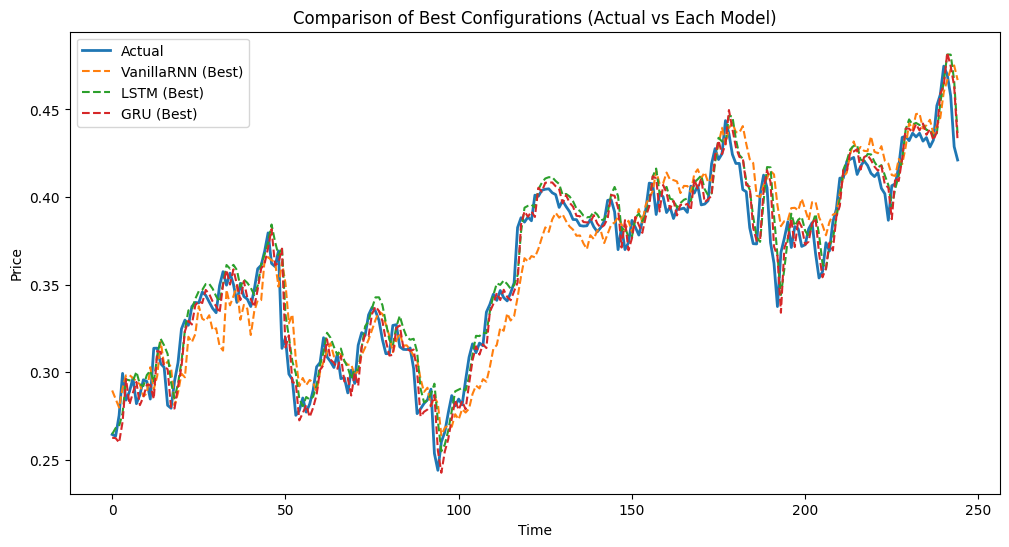

In [127]:
#comparison of the best configurations on a single graph
plt.figure(figsize=(12, 6))
actuals_any = best_config_per_model['VanillaRNN']['actuals']
plt.plot(actuals_any, label="Actual", linewidth=2)

for mtype, details in best_config_per_model.items():
    plt.plot(details['predictions'], label=f"{mtype} (Best)", linestyle='--')

plt.title("Comparison of Best Configurations (Actual vs Each Model)")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()